# Setup

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import uncertainties.unumpy as unp
import uncertainties as unc
from scipy.optimize import curve_fit 
from scipy import stats

In [2]:
plt.style.use('fivethirtyeight')

# Data visualization ― week 4

![](images/weightedreg1.png)

# Agenda

* Week 3 wrap-up
* Problem set discussion
* Visualizing statistical estimates and fits
    - uncertainty in estimates
    - plotting causal effects estimated via regression
    - comparing causal effects across groups

# Uncertainty in estimates

When it comes to visualize the output of statistical analyses, there are two forms of uncertainty the could be represented:

1. sometimes, we'd like to infer a quantity of interest in the population (e.g., average salary) - however, we have sample data only
2. sometimes, we'd like to infer the effect of an independent variable $X$ on a dependent variable $Y$ (e.g., the effect of schooling on salary) - however, the $X - Y$ effect is estimated via a regression model or machine learning

# Case 1: Sample estimate Vs. population value

Let's use the killer app data to show the uncertainty in the 

In [5]:
# read data
df = pd.read_csv('data/killerAps/data.csv')

In [6]:
# get a random sample containing 1%
# of the apps in the population
smp = df.sample(frac=0.01)

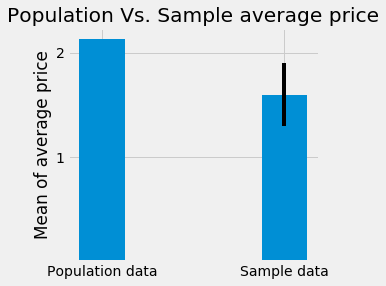

In [23]:
# create figure
fig = plt.figure(figsize=(4, 4))

# parms for the figure
width = 0.25

# add plot
ax = fig.add_subplot(1, 1, 1)

# get data series
pos = (0, 1)
labels = ('Population data', 'Sample data')
means = (np.mean(df['avprice']), np.mean(smp['avprice']))
err = (0, np.std(smp['avprice'])/np.sqrt(len(smp)))

# quick and dirty plot
ax.bar(pos, means, width, yerr=err)

# labels
ax.set_ylabel('Mean of average price')
ax.set_yticks((1, 2))
ax.set_title('Population Vs. Sample average price')
ax.set_xticks(pos)
ax.set_xticklabels(labels)

# show plot
plt.show()

# Case 2: 

In [31]:
df = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable1.dta')

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
